<center> <h1><b>Analysis and Machine Learning-Based Detection of Brute-Force Attacks in IIoT</b></h1> </center>

**Author(s):** Yassin BIBRINE & Ali ACHENAN   
**Abstract:** This notebook presents a comprehensive analysis of brute-force attacks within Industrial Internet of Things (IIoT) networks. By processing network traffic captures using advanced tools like Zeek, we structure raw data into actionable datasets for machine learning-based intrusion detection. The workflow emphasizes methodological rigor, reproducibility, and the integration of protocol-aware features to distinguish malicious authentication attempts from benign traffic. Two dataset versions (V1: comprehensive merge; V2: targeted brute-force logs) are generated to support exploratory analysis and model training.

## 1. Introduction

### 1.1 Background and Motivation

The **Industrial Internet of Things (IIoT)** integrates sensors, actuators, and industrial control systems such as *Programmable Logic Controllers (PLCs)* and *SCADA systems* into interconnected networked environments. This convergence enables automation, real-time monitoring, and data-driven decision-making in critical sectors like manufacturing and energy. However, it also exposes legacy systems and resource-constrained devices to cybersecurity threats, including **Distributed Denial-of-Service (DDoS) attacks**, reconnaissance scanning, web-based injections, and unauthorized access attempts.

The motivation for this research stems from the increasing vulnerability of IIoT ecosystems. Traditional security measures often fail against adaptive threats, necessitating data-driven approaches. By analyzing real-world IIoT network traffic encompassing both benign and malicious behaviors we aim to uncover attack dynamics, identify behavioral patterns, and develop **Intrusion Detection Systems (IDS)** powered by machine learning for enhanced adaptability and accuracy.

### 1.2 Research Focus: Brute-Force Attacks

Among IIoT threats, **brute-force attacks** are prevalent, involving systematic trial-and-error of username/password combinations to gain unauthorized access. These attacks target services like **Secure Shell (SSH)** for remote access, **HTTP** for web interfaces, and **MQTT** for authentication-dependent messaging in IIoT. Successful breaches can result in process manipulation, data exfiltration, or lateral movement, potentially disrupting critical infrastructure.

Understanding brute-force dynamics requires examining high-rate authentication failures, session durations, and traffic anomalies concepts rooted in behavioral anomaly detection theory.

### 1.3 Analytical and Machine Learning Objectives

The primary objective is to design and train machine learning models for predicting brute-force attacks in IIoT networks. This involves:
1. Structuring raw network traffic into protocol-aware event logs.
2. Analyzing authentication behaviors and traffic patterns.
3. Developing predictive models to classify malicious vs. legitimate access.

Emphasis is placed on reproducibility, robustness, and cross-validation to ensure models generalize across diverse IIoT deployments.

## 2. Methodology

### 2.1 Tools and Technologies

#### Zeek Network Security Monitor
- A passive analysis framework that transforms raw packet captures (PCAPs) into semantic, protocol-specific logs (`conn.log` for connections, `ssh.log` for authentication events).
- Outputs in line-delimited JSON for seamless integration into data pipelines.
- Chosen over alternatives like TShark due to its behavioral abstraction: Zeek extracts security-relevant features such as authentication failures and session metadata at a higher level, simplifying brute-force pattern detection without manual packet reconstruction.

#### Python and Pandas
- Employed for ingesting JSON logs, preserving protocol fields, and enriching with metadata (device type, PCAP source).
- Facilitates merging into structured CSVs, enabling exploratory data analysis (EDA) and machine learning preprocessing.

### 2.2 Data Pipeline Overview

The pipeline follows: Raw PCAPs → **Zeek** (JSON log generation) → **Python/Pandas** (structuring and annotation) → **Analysis and ML Modeling**.

This approach ensures traceability and scalability, addressing challenges like data volume and protocol diversity in IIoT traffic.

## 3. Data Preparation

### 3.1 Phase 1: Comprehensive Data Merging (V1)

In this phase, all Zeek logs from multiple PCAP folders are merged into a single CSV (`merged_data_V1.csv`). This version provides a holistic view of network events, including metadata for contextual analysis. It is ideal for broad exploratory studies but may include irrelevant logs for targeted brute-force detection.

#### 3.1.1 Imports and Setup

We import essential libraries and define paths. `glob` is used for pattern-matching log files, ensuring efficient traversal of directory structures.

In [5]:
import os
import pandas as pd
from glob import glob

# Path to your 8 folders
base_path = "zeek_logs"

# Where the final CSV will be saved
output_csv = "merged_data_V1.csv"

#### 3.1.2 Folder Discovery

Identify PCAP folders, each representing a device or attack scenario. This modular approach supports scalability for larger datasets.

In [6]:
# Each folder corresponds to one device / PCAP
pcap_folders = [f.path for f in os.scandir(base_path) if f.is_dir()]
pcap_folders

['zeek_logs\\attack_bruteforce_dictionary-ssh_ap',
 'zeek_logs\\attack_bruteforce_dictionary-ssh_edge1',
 'zeek_logs\\attack_bruteforce_dictionary-ssh_mqtt-broker',
 'zeek_logs\\attack_bruteforce_dictionary-ssh_router',
 'zeek_logs\\attack_bruteforce_dictionary-ssh_switch',
 'zeek_logs\\attack_bruteforce_dictionary-telnet_ap',
 'zeek_logs\\attack_bruteforce_dictionary-telnet_edge1',
 'zeek_logs\\attack_bruteforce_dictionary-telnet_mqtt-broker']

#### 3.1.3 Helper Function for Log Reading

This function reads Zeek's JSON logs, handling line-delimited formats common in network analysis. Metadata enrichment (`pcap_id`, `device_type`) facilitates downstream filtering and grouping, crucial for multi-device IIoT studies.

In [7]:
def read_log_file_json(file_path, log_type, pcap_id, device_type):
    """
    Reads a Zeek JSON log file (.log) and adds metadata columns
    """
    try:
        # Read JSON lines (Zeek JSON logs are usually line-delimited JSON)
        df = pd.read_json(file_path, lines=True)
    except Exception as e:
        print(f"Failed to read {file_path}: {e}")
        return pd.DataFrame()

    # Add metadata
    df['pcap_id'] = pcap_id
    df['device_type'] = device_type
    df['log_type'] = log_type

    return df

#### 3.1.4 Example Processing for a Single Folder

Demonstrate log concatenation for one folder. This step verifies data integrity, revealing fields like timestamps (`ts`), connection UIDs, and protocol details—key for temporal analysis in attack detection.

In [8]:
example_folder = pcap_folders[0]
device_type = os.path.basename(example_folder)
all_logs = []

for log_file in glob(os.path.join(example_folder, "*.log")):
    log_type = os.path.splitext(os.path.basename(log_file))[0]
    df_log = read_log_file_json(log_file, log_type, pcap_id=device_type, device_type=device_type)
    if not df_log.empty:
        all_logs.append(df_log)

folder_df = pd.concat(all_logs, ignore_index=True)
folder_df.head()

,ts,analyzer_kind,analyzer_name,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,failure_reason,...,host_key_alg,host_key,auth_success,cipher,resumed,established,ssl_history,name,notice,peer
0,1.739537e+09,packet,TEREDO,CwwNM63C3opLA8MFR2,192.168.1.205,38822.0,255.255.255.255,29810.0,udp,Truncated Teredo or invalid inner IP version,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.739537e+09,NaN,NaN,CGxBxl3en6yMbdxKA8,192.168.1.87,50336.0,54.69.37.156,443.0,tcp,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.739537e+09,NaN,NaN,CwzJvg1V59ReXXjaX4,192.168.1.100,39252.0,192.168.1.205,22.0,tcp,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.739537e+09,NaN,NaN,CfFBkf1cfOee8KQDra,192.168.1.102,58918.0,8.8.8.8,53.0,udp,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.739537e+09,NaN,NaN,C9LdHVV0aUXR0rvT9,192.168.1.52,43544.0,192.168.1.1,1900.0,tcp,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 3.1.5 Descriptive Statistics for Example Folder

Generate summary statistics to inspect data distribution, identifying outliers in features like duration or byte counts potential indicators of brute-force persistence.

In [9]:
folder_df.describe()

,ts,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,...,total_bytes,missing_bytes,overflow_bytes,trans_depth,request_body_len,response_body_len,status_code,payload_len,auth_attempts,auth_success
count,2.413000e+03,2412.000000,2412.000000,295.000000,293.000000,293.000000,325.000000,325.000000,325.000000,325.000000,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1838.000000,75.000000,4.0
mean,1.739548e+09,52336.210199,1886.762438,21.303813,15706.634812,37239.204778,0.590769,141.427692,20964.175385,139.870769,...,134.0,0.0,0.0,1.0,0.0,134.0,404.0,4.844396,0.346667,0.0
std,5.348213e+05,7873.278583,3254.432565,40.669371,32273.205074,75872.531500,7.519229,285.587588,42829.427294,286.627606,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.234774,1.474956,0.0
min,1.739537e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,134.0,0.0,0.0,1.0,0.0,134.0,404.0,0.000000,0.000000,0.0
25%,1.739537e+09,50692.000000,1883.000000,0.023856,44.000000,44.000000,0.000000,1.000000,72.000000,1.000000,...,134.0,0.0,0.0,1.0,0.0,134.0,404.0,2.000000,0.000000,0.0
50%,1.739537e+09,52268.000000,1883.000000,0.025027,44.000000,44.000000,0.000000,1.000000,72.000000,1.000000,...,134.0,0.0,0.0,1.0,0.0,134.0,404.0,3.000000,0.000000,0.0
75%,1.739537e+09,55866.000000,1883.000000,7.803232,4512.000000,1018.000000,0.000000,24.000000,4800.000000,11.000000,...,134.0,0.0,0.0,1.0,0.0,134.0,404.0,5.000000,0.000000,0.0
max,1.765808e+09,64829.000000,53611.000000,121.569801,270938.000000,194730.000000,96.000000,772.000000,137724.000000,780.000000,...,134.0,0.0,0.0,1.0,0.0,134.0,404.0,16.000000,7.000000,0.0


#### 3.1.6 Full Dataset Merging (V1)

Aggregate logs across all folders into a master DataFrame. This results in a wide dataset (many columns due to varying log schemas), suitable for feature engineering in ML pipelines.

In [10]:
all_folders_dfs = []

for folder in pcap_folders:
    device_type = os.path.basename(folder)
    folder_logs = []

    for log_file in glob(os.path.join(folder, "*.log")):
        log_type = os.path.splitext(os.path.basename(log_file))[0]
        df_log = read_log_file_json(log_file, log_type, pcap_id=device_type, device_type=device_type)
        if not df_log.empty:
            folder_logs.append(df_log)

    if folder_logs:
        folder_df = pd.concat(folder_logs, ignore_index=True)
        all_folders_dfs.append(folder_df)

master_df = pd.concat(all_folders_dfs, ignore_index=True)
master_df.head()

,ts,analyzer_kind,analyzer_name,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,failure_reason,...,certificate.key_alg,certificate.sig_alg,certificate.key_type,certificate.key_length,certificate.exponent,host_cert,client_cert,san.dns,basic_constraints.ca,basic_constraints.path_len
0,1.739537e+09,packet,TEREDO,CwwNM63C3opLA8MFR2,192.168.1.205,38822.0,255.255.255.255,29810.0,udp,Truncated Teredo or invalid inner IP version,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.739537e+09,NaN,NaN,CGxBxl3en6yMbdxKA8,192.168.1.87,50336.0,54.69.37.156,443.0,tcp,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.739537e+09,NaN,NaN,CwzJvg1V59ReXXjaX4,192.168.1.100,39252.0,192.168.1.205,22.0,tcp,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.739537e+09,NaN,NaN,CfFBkf1cfOee8KQDra,192.168.1.102,58918.0,8.8.8.8,53.0,udp,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.739537e+09,NaN,NaN,C9LdHVV0aUXR0rvT9,192.168.1.52,43544.0,192.168.1.1,1900.0,tcp,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 3.1.7 Export V1 Dataset

Save the merged dataset for persistence. Note: JSON logs were preferred over raw metadata for their rich behavioral insights, aligning with brute-force detection needs.

In [11]:
master_df.to_csv(output_csv, index=False)
print(f"Merged CSV saved to {output_csv}")

Merged CSV saved to merged_data_V1.csv


#### 3.1.8 Dataset Dimensions

Inspect shape to confirm successful merging, highlighting the dataset's scale for ML feasibility.

In [12]:
master_df.shape

(35988, 130)

#### 3.1.9 Preview Merged Data

Display header to verify the structure, noting that sparse columns of record variation are a common challenge in network data fusion.

In [13]:
master_df.head()

,ts,analyzer_kind,analyzer_name,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,failure_reason,...,certificate.key_alg,certificate.sig_alg,certificate.key_type,certificate.key_length,certificate.exponent,host_cert,client_cert,san.dns,basic_constraints.ca,basic_constraints.path_len
0,1.739537e+09,packet,TEREDO,CwwNM63C3opLA8MFR2,192.168.1.205,38822.0,255.255.255.255,29810.0,udp,Truncated Teredo or invalid inner IP version,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.739537e+09,NaN,NaN,CGxBxl3en6yMbdxKA8,192.168.1.87,50336.0,54.69.37.156,443.0,tcp,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.739537e+09,NaN,NaN,CwzJvg1V59ReXXjaX4,192.168.1.100,39252.0,192.168.1.205,22.0,tcp,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.739537e+09,NaN,NaN,CfFBkf1cfOee8KQDra,192.168.1.102,58918.0,8.8.8.8,53.0,udp,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.739537e+09,NaN,NaN,C9LdHVV0aUXR0rvT9,192.168.1.52,43544.0,192.168.1.1,1900.0,tcp,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.2 Optimized Data Preparation (V2: Brute-Force Relevant Logs)

V2 filters for logs directly pertinent to brute-force detection such as SSH, HTTP, MQTT and connections. This reduces noise, focusing on features like authentication attempts and payload lengths essential for time-window-based anomaly detection models.

#### 3.2.1 Define Relevant Log Types

Select logs capturing authentication events, informed by protocol vulnerabilities in IIoT.

In [14]:
BRUTEFORCE_LOG_TYPES = {
    "ssh",
    "conn",
    "http",
    "mqtt_publish"
}

#### 3.2.2 Optimized Log Reading Function

Early filtering skips irrelevant logs, optimizing for efficiency in large-scale processing.

In [15]:
def read_json_log(file_path, pcap_id, device_type):
    log_type = os.path.splitext(os.path.basename(file_path))[0]

    # Skip non–bruteforce logs early
    if log_type not in BRUTEFORCE_LOG_TYPES:
        return None

    try:
        df = pd.read_json(file_path, lines=True)
    except Exception as e:
        print(f"[!] Failed to read {file_path}: {e}")
        return None

    # Metadata
    df["pcap_id"] = pcap_id
    df["device_type"] = device_type
    df["log_type"] = log_type

    return df

#### 3.2.3 Collect Brute-Force Logs

Iterate folders, collecting only targeted logs to form the V2 dataset.

In [16]:
bf_logs = []

for folder in pcap_folders:
    device_type = os.path.basename(folder)
    pcap_id = device_type  # or use another naming scheme

    for log_file in glob(os.path.join(folder, "*.log")):
        df = read_json_log(log_file, pcap_id, device_type)
        if df is not None and not df.empty:
            bf_logs.append(df)

len(bf_logs)

27

#### 3.2.4 Concatenate and Inspect V2 Dataset

Merge and check dimensions, ensuring focus on brute-force indicators.

In [17]:
bf_df = pd.concat(bf_logs, ignore_index=True)

bf_df.shape

(34578, 53)

#### 3.2.5 Log Type Distribution

Analyze counts to confirm emphasis on relevant protocols (e.g., MQTT for IIoT messaging).

In [18]:
bf_df["log_type"].value_counts()

log_type
mqtt_publish    28246
conn             6168
ssh               133
http               31
Name: count, dtype: int64

#### 3.2.6 Export V2 Dataset

Save for subsequent ML stages, such as feature extraction from authentication fields.

In [19]:
output_csv = "merged_data_V2.csv"

bf_df.to_csv(output_csv, index=False)

import os
print("Saved to:", os.path.abspath(output_csv))

Saved to: c:\vs code projects\bruteforce_ai_detection\merged_data_V2.csv


## 4. Discussion and Next Steps

The generated datasets (V1 and V2) provide a foundation for advanced analysis. Future work includes:
- Feature engineering (e.g., aggregating attempts per time window).
- Model training using classifiers like Random Forests or Neural Networks.
- Evaluation metrics focused on precision/recall for imbalanced attack data.

This pipeline advances IIoT security by bridging raw traffic analysis with predictive modeling.

# phase 2:

Authors: Meryem Cherkaoui & Hajar Ait- Ouarab.

In the Exploratory Data Analysis (EDA) phase, we aim to thoroughly understand the structure, quality, and behavioral patterns of the network traffic dataset used for brute force attack detection. This phase begins with a global inspection of the data, including its dimensionality, data types, and the presence of missing values. We then perform a light data cleaning process to handle incomplete or inconsistent entries while preserving potentially meaningful anomalies. Temporal analysis is conducted to study traffic evolution over time and to identify abnormal activity bursts that may indicate automated brute force attempts. Furthermore, we analyze source IP addresses, destination ports, and services to detect highly repetitive connection patterns and frequently targeted services. Connection states, traffic volume, and session duration are also examined to distinguish failed authentication attempts from normal connections. Through statistical analysis and informative visualizations, we identify outliers and suspicious behaviors, and we engineer preliminary features that highlight brute force characteristics. Overall, the EDA phase provides critical insights that guide feature selection, anomaly detection strategies, and the development of robust machine learning models in later stages of the project.

In [20]:
#Visualisation

In [21]:
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Interactive Visualization
import plotly.express as px
import plotly.graph_objects as go

# Warning Management
import warnings
warnings.filterwarnings("ignore")

# Visual Settings (ou Plotting Parameters)
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [22]:
df = pd.read_csv("merged_data_V2.csv")
df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,duration,orig_bytes,resp_bytes,...,auth_attempts,client,server,cipher_alg,mac_alg,compression_alg,kex_alg,host_key_alg,host_key,auth_success
0,1.739537e+09,CGxBxl3en6yMbdxKA8,192.168.1.87,50336,54.69.37.156,443,tcp,0.116701,0.0,389.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.739537e+09,CwzJvg1V59ReXXjaX4,192.168.1.100,39252,192.168.1.205,22,tcp,0.141500,1302.0,1018.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.739537e+09,CfFBkf1cfOee8KQDra,192.168.1.102,58918,8.8.8.8,53,udp,0.024259,32.0,107.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.739537e+09,C9LdHVV0aUXR0rvT9,192.168.1.52,43544,192.168.1.1,1900,tcp,0.005341,60.0,279.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.739537e+09,CqBZme1GGnrbj6tdG9,192.168.1.205,52487,8.8.4.4,53,udp,0.023983,44.0,44.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df.shape


(34578, 53)

In [24]:
# Convert Unix timestamp (seconds) to readable datetime format
df['ts'] = pd.to_datetime(df['ts'], unit='s')

# Sort the dataset chronologically by timestamp
df = df.sort_values(by='ts')

In [25]:

df

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,duration,orig_bytes,resp_bytes,...,auth_attempts,client,server,cipher_alg,mac_alg,compression_alg,kex_alg,host_key_alg,host_key,auth_success
24624,2025-02-13 20:09:40.849479914,CStZM495Bi0yks39i,192.168.1.87,49154,255.255.255.255,6667,udp,301.548325,8772.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24636,2025-02-13 20:09:40.968379021,CaeCVPMs3WkmSmUBb,192.168.1.88,49155,255.255.255.255,6667,udp,297.996160,10148.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24639,2025-02-13 20:09:40.980211020,CIFd7p2odaxOCJ8Cw6,192.168.1.83,40463,35.84.67.65,8886,tcp,242.685527,345.0,345.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24670,2025-02-13 20:09:41.119806051,C3QYjPedokLwvR8u3,192.168.1.15,56304,192.168.1.193,1883,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24627,2025-02-13 20:09:41.119806051,C3QYjPedokLwvR8u3,192.168.1.15,56304,192.168.1.193,1883,tcp,301.332054,12942.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24155,2025-02-14 18:58:44.191435099,CPomJj3TFBjdqCqK6e,192.168.1.18,53534,192.168.1.193,1883,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24157,2025-02-14 18:58:44.193917036,CPomJj3TFBjdqCqK6e,192.168.1.18,53534,192.168.1.193,1883,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24158,2025-02-14 18:58:44.223303080,CMbDsFgNRLH4JaMe,192.168.1.13,63119,192.168.1.193,1883,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24159,2025-02-14 18:58:44.246867895,C3Zgi61hHqtD20gHKj,192.168.1.11,49463,192.168.1.193,1883,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34578 entries, 24624 to 24160
Data columns (total 53 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ts                 34578 non-null  datetime64[ns]
 1   uid                34578 non-null  object        
 2   id.orig_h          34578 non-null  object        
 3   id.orig_p          34578 non-null  int64         
 4   id.resp_h          34578 non-null  object        
 5   id.resp_p          34578 non-null  int64         
 6   proto              6168 non-null   object        
 7   duration           4934 non-null   float64       
 8   orig_bytes         4934 non-null   float64       
 9   resp_bytes         4934 non-null   float64       
 10  conn_state         6168 non-null   object        
 11  local_orig         6168 non-null   object        
 12  local_resp         6168 non-null   object        
 13  missed_bytes       6168 non-null   float64       
 14  history

In [27]:

df.describe()

,ts,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,ip_proto,trans_depth,version,request_body_len,response_body_len,status_code,payload_len,auth_attempts,auth_success
count,34578,34578.00000,34578.000000,4.934000e+03,4934.000000,4934.000000,6168.000000,6168.000000,6168.000000,6168.000000,6168.000000,6168.000000,31.0,164.000000,31.0,31.0,31.0,28246.000000,133.000000,60.0
mean,2025-02-14 06:24:03.464133376,52533.63523,1874.921366,2.076089e+01,2266.545197,2363.378597,0.828794,16.759403,2250.419423,15.067445,2605.874676,8.724546,1.0,1.829878,0.0,134.0,404.0,4.847837,2.278195,0.0
min,2025-02-13 20:09:40.849479914,0.00000,0.000000,9.536743e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,1.100000,0.0,134.0,404.0,0.000000,0.000000,0.0
25%,2025-02-13 20:19:20.721399552,50692.00000,1883.000000,4.820824e-04,0.000000,0.000000,0.000000,1.000000,60.000000,1.000000,40.000000,6.000000,1.0,2.000000,0.0,134.0,404.0,2.000000,0.000000,0.0
50%,2025-02-14 03:28:20.019486720,52459.00000,1883.000000,7.030964e-04,0.000000,0.000000,0.000000,1.000000,60.000000,1.000000,40.000000,6.000000,1.0,2.000000,0.0,134.0,404.0,3.000000,0.000000,0.0
75%,2025-02-14 12:48:00.832565760,55866.00000,1883.000000,2.384168e-02,44.000000,0.000000,0.000000,1.000000,72.000000,1.000000,40.000000,17.000000,1.0,2.000000,0.0,134.0,404.0,5.000000,5.000000,0.0
max,2025-02-14 18:58:44.351233959,65350.00000,59995.000000,3.017096e+02,671993.000000,194730.000000,2460.000000,797.000000,372755.000000,800.000000,235298.000000,58.000000,1.0,2.000000,0.0,134.0,404.0,16.000000,7.000000,0.0
std,NaN,8204.67266,3008.190249,6.620580e+01,23711.846143,20563.123520,44.326931,87.229019,15294.240420,87.318734,22307.619583,5.178585,0.0,0.353454,0.0,0.0,0.0,4.229142,2.541633,0.0


In [28]:

df.columns

Index(['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p',
       'proto', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state',
       'local_orig', 'local_resp', 'missed_bytes', 'history', 'orig_pkts',
       'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'ip_proto', 'service',
       'pcap_id', 'device_type', 'log_type', 'trans_depth', 'method', 'host',
       'uri', 'version', 'request_body_len', 'response_body_len',
       'status_code', 'status_msg', 'tags', 'resp_fuids', 'resp_mime_types',
       'from_client', 'retain', 'qos', 'status', 'topic', 'payload',
       'payload_len', 'auth_attempts', 'client', 'server', 'cipher_alg',
       'mac_alg', 'compression_alg', 'kex_alg', 'host_key_alg', 'host_key',
       'auth_success'],
      dtype='object')

In [29]:

df.dtypes

ts                   datetime64[ns]
uid                          object
id.orig_h                    object
id.orig_p                     int64
id.resp_h                    object
id.resp_p                     int64
proto                        object
duration                    float64
orig_bytes                  float64
resp_bytes                  float64
conn_state                   object
local_orig                   object
local_resp                   object
missed_bytes                float64
history                      object
orig_pkts                   float64
orig_ip_bytes               float64
resp_pkts                   float64
resp_ip_bytes               float64
ip_proto                    float64
service                      object
pcap_id                      object
device_type                  object
log_type                     object
trans_depth                 float64
method                       object
host                         object
uri                         

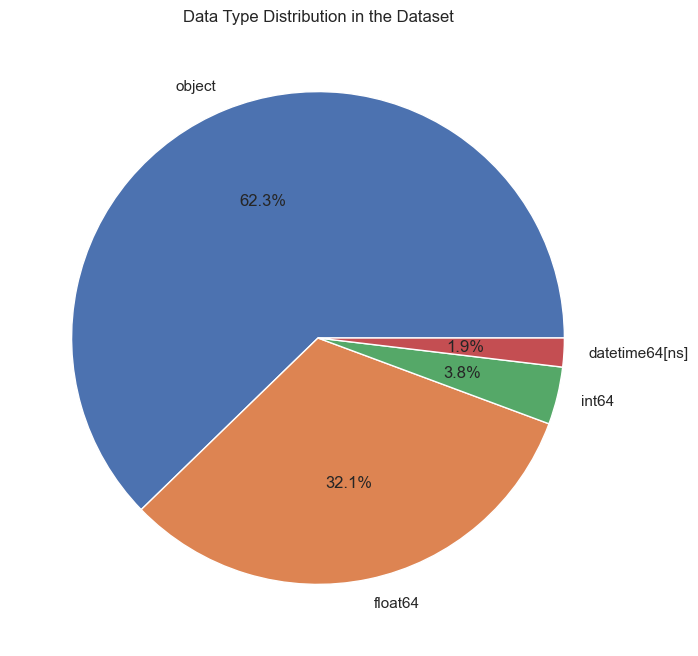

In [30]:
# Count the number of columns per data type
df.dtypes.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))

# Set the chart title and labels
plt.title('Data Type Distribution in the Dataset')
plt.ylabel('')
plt.show()

In [31]:

df.duplicated().sum()

np.int64(0)

In [32]:

df.isna().sum()

ts                       0
uid                      0
id.orig_h                0
id.orig_p                0
id.resp_h                0
id.resp_p                0
proto                28410
duration             29644
orig_bytes           29644
resp_bytes           29644
conn_state           28410
local_orig           28410
local_resp           28410
missed_bytes         28410
history              28698
orig_pkts            28410
orig_ip_bytes        28410
resp_pkts            28410
resp_ip_bytes        28410
ip_proto             28410
service              32994
pcap_id                  0
device_type              0
log_type                 0
trans_depth          34547
method               34547
host                 34547
uri                  34547
version              34414
request_body_len     34547
response_body_len    34547
status_code          34547
status_msg           34547
tags                 34547
resp_fuids           34547
resp_mime_types      34547
from_client           6332
r

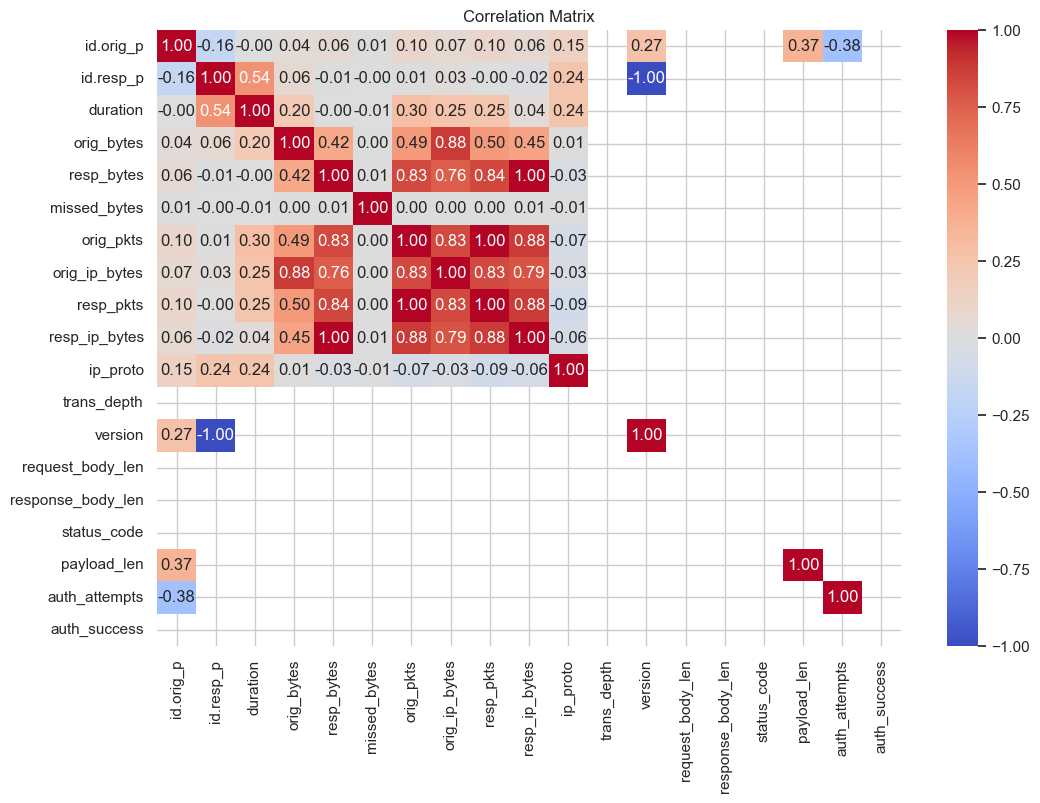

In [33]:
# 1. Select only numeric columns
df__numeric = df.select_dtypes(include=[np.number])

# 2. Calculate the correlation on df_numeric
corr = df__numeric.corr()

# 3. Display the heatmap
plt.figure(figsize=(12, 8)) # Optional: to enlarge the figure
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

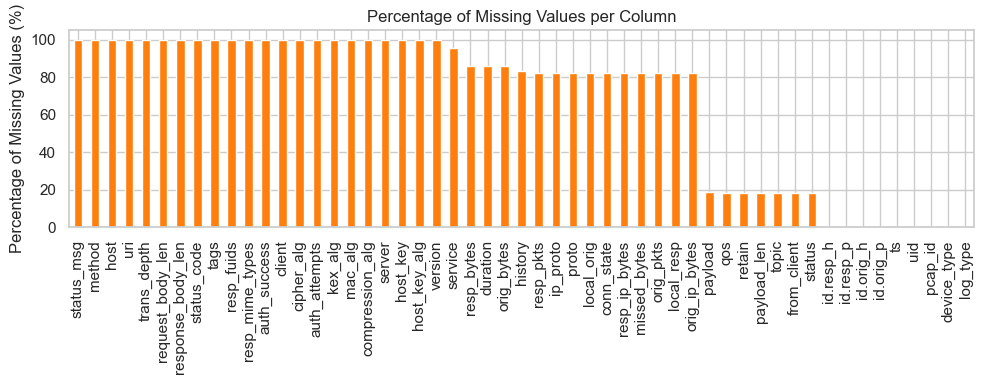

In [34]:
_mdf = df.copy()

# Calculate the percentage of missing values per column
miss_pct = _mdf.isna().mean() * 100

plt.figure(figsize=(10,4))
miss_pct.sort_values(ascending=False).plot(kind="bar", color="tab:orange")

# Set axis labels and chart title
plt.ylabel("Percentage of Missing Values (%)")
plt.title("Percentage of Missing Values per Column")

plt.tight_layout()
plt.show()

In [35]:
# 99.9% Threshold: drop columns if they have more than 99.9% missing values
threshold = 0.999

# Calculate the percentage of missing values
miss_pct = df.isna().mean()

# Select columns to keep (those below the threshold)
useful_columns = miss_pct[miss_pct <= threshold].index

# Create the new filtered DataFrame
df1 = df[useful_columns]

# Print the results
print(f"Initial columns: {df.shape[1]}")
print(f"Retained columns: {df1.shape[1]}")

Initial columns: 53
Retained columns: 42


In [36]:
cols_eda = [
    'ts', 'uid', 'id.orig_h', 'id.resp_p', 'service', 
    'duration', 'conn_state', 'history', 
    'orig_pkts', 'resp_pkts', 'orig_ip_bytes', 'resp_ip_bytes'
]

df1 = df1[cols_eda].copy()


In [37]:
df1


,ts,uid,id.orig_h,id.resp_p,service,duration,conn_state,history,orig_pkts,resp_pkts,orig_ip_bytes,resp_ip_bytes
24624,2025-02-13 20:09:40.849479914,CStZM495Bi0yks39i,192.168.1.87,6667,NaN,301.548325,S0,D,51.0,0.0,10200.0,0.0
24636,2025-02-13 20:09:40.968379021,CaeCVPMs3WkmSmUBb,192.168.1.88,6667,NaN,297.996160,S0,D,59.0,0.0,11800.0,0.0
24639,2025-02-13 20:09:40.980211020,CIFd7p2odaxOCJ8Cw6,192.168.1.83,8886,NaN,242.685527,OTH,DdA,10.0,5.0,745.0,545.0
24670,2025-02-13 20:09:41.119806051,C3QYjPedokLwvR8u3,192.168.1.15,1883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24627,2025-02-13 20:09:41.119806051,C3QYjPedokLwvR8u3,192.168.1.15,1883,mqtt,301.332054,OTH,DadA,607.0,607.0,37222.0,24290.0
...,...,...,...,...,...,...,...,...,...,...,...,...
24155,2025-02-14 18:58:44.191435099,CPomJj3TFBjdqCqK6e,192.168.1.18,1883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24157,2025-02-14 18:58:44.193917036,CPomJj3TFBjdqCqK6e,192.168.1.18,1883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24158,2025-02-14 18:58:44.223303080,CMbDsFgNRLH4JaMe,192.168.1.13,1883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24159,2025-02-14 18:58:44.246867895,C3Zgi61hHqtD20gHKj,192.168.1.11,1883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:

# True if NaN, False otherwise
df1.isna().sum()

ts                   0
uid                  0
id.orig_h            0
id.resp_p            0
service          32994
duration         29644
conn_state       28410
history          28698
orig_pkts        28410
resp_pkts        28410
orig_ip_bytes    28410
resp_ip_bytes    28410
dtype: int64

In [39]:
# Handle missing values for numerical columns by filling them with 0
num_cols = ["duration", "orig_pkts", "resp_pkts", "orig_ip_bytes", "resp_ip_bytes"]
for col in num_cols:
    df1[col] = df1[col].fillna(0)

# Handle missing values for categorical columns by labeling them as "unknown"
df1["service"] = df1["service"].fillna("unknown")
df1["conn_state"] = df1["conn_state"].fillna("unknown")
df1["history"] = df1["history"].fillna("unknown")

In [40]:
df1.isna().sum()

ts               0
uid              0
id.orig_h        0
id.resp_p        0
service          0
duration         0
conn_state       0
history          0
orig_pkts        0
resp_pkts        0
orig_ip_bytes    0
resp_ip_bytes    0
dtype: int64

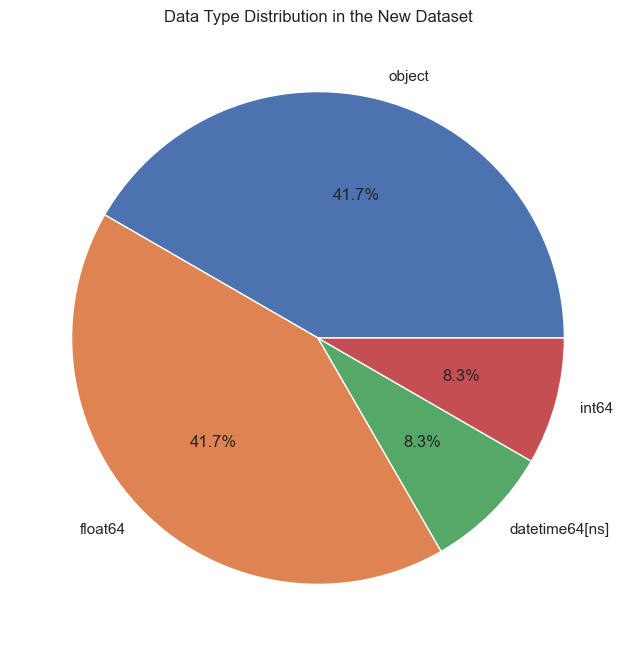

In [42]:
# Plot the distribution of data types in the cleaned dataset
df1.dtypes.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))

# Set the chart title and remove the y-axis label
plt.title('Data Type Distribution in the New Dataset')
plt.ylabel('')

plt.show()

<Axes: xlabel='service'>

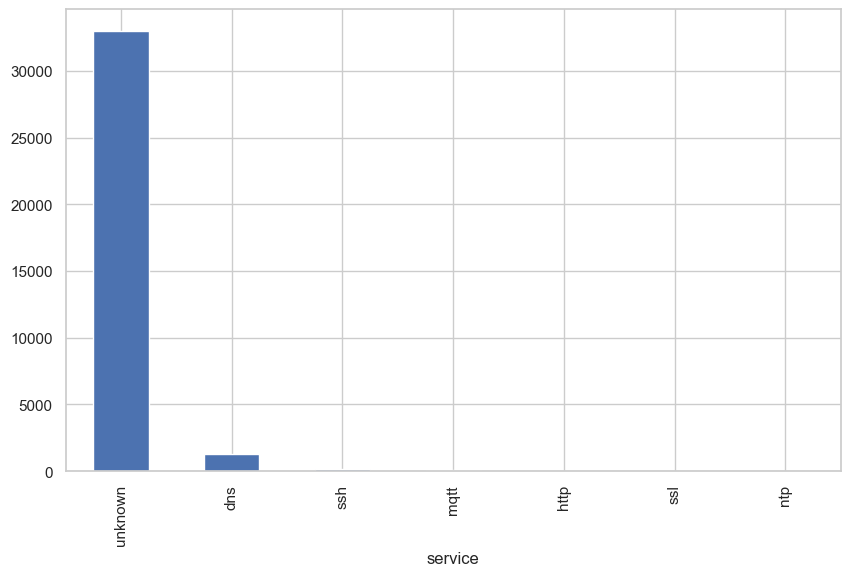

In [43]:
# Duration by service (boxplot)
df1['service'].value_counts().plot(kind='bar')

In [44]:
# Selection of numeric columns
numeric_cols = df1.select_dtypes(include='number').columns

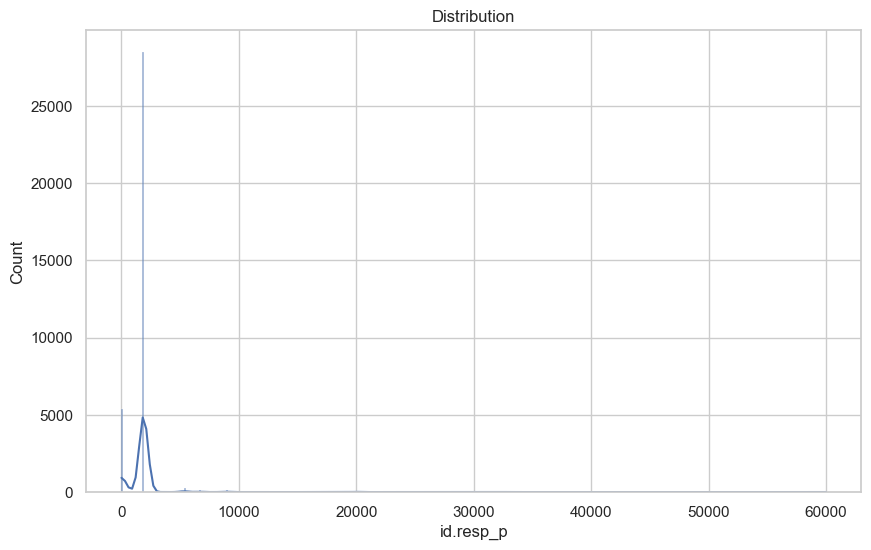

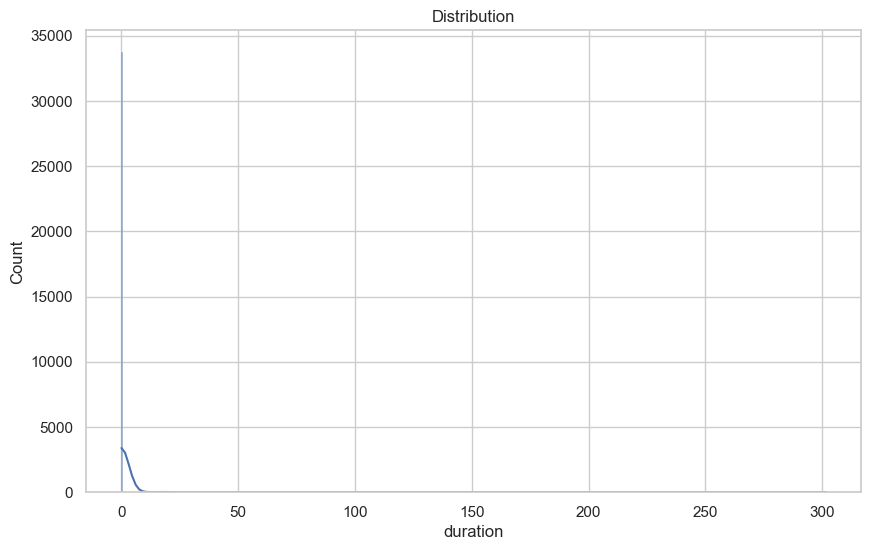

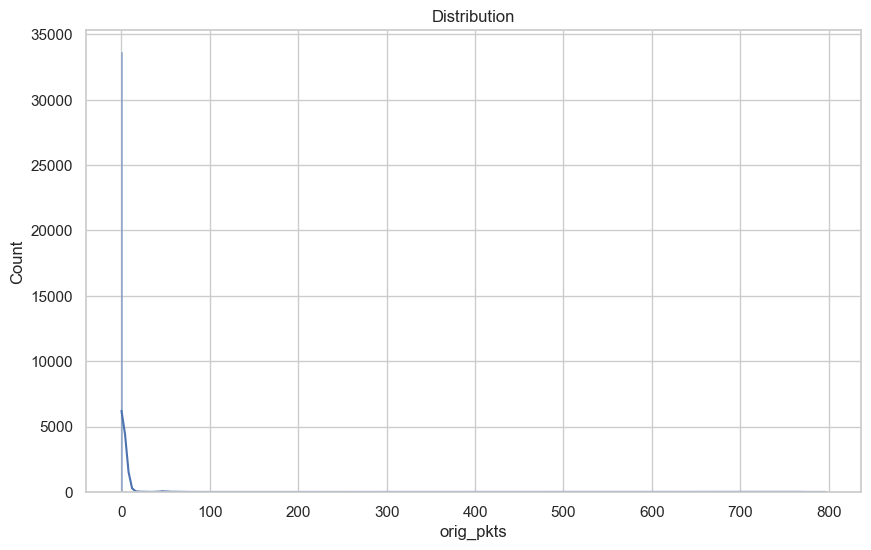

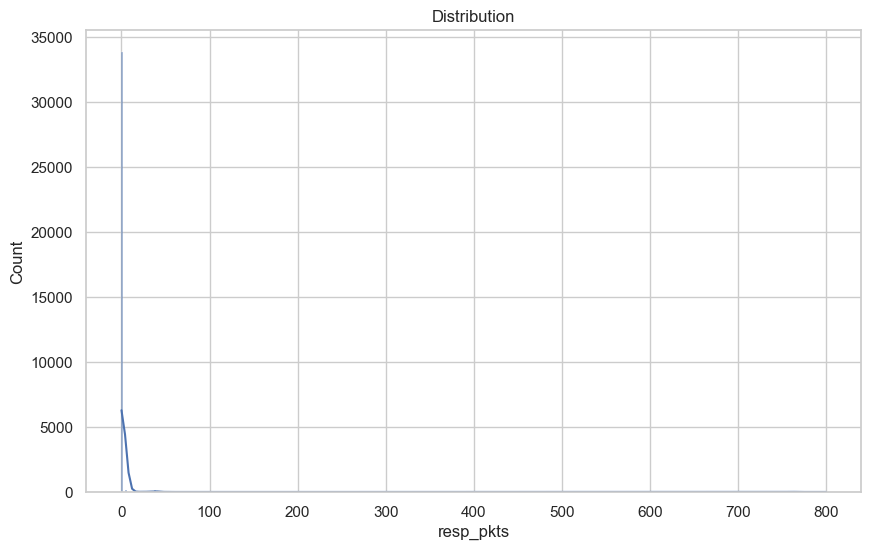

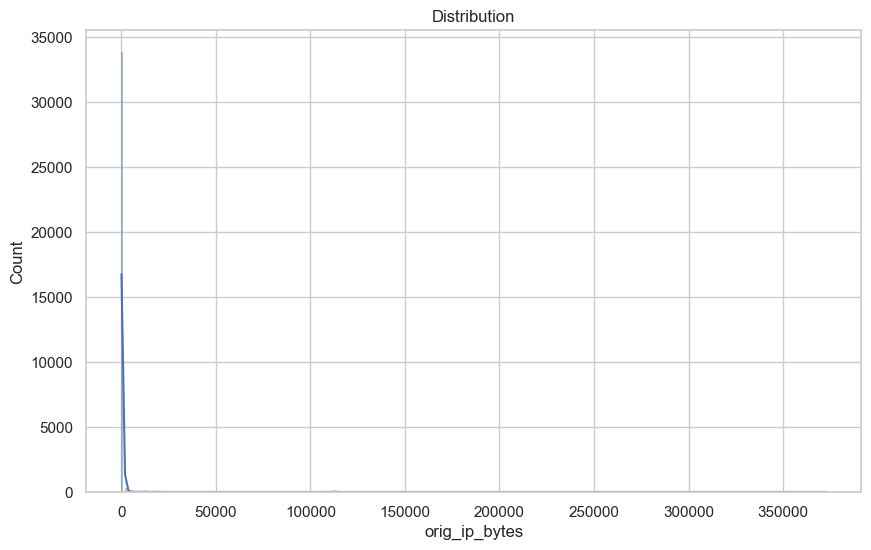

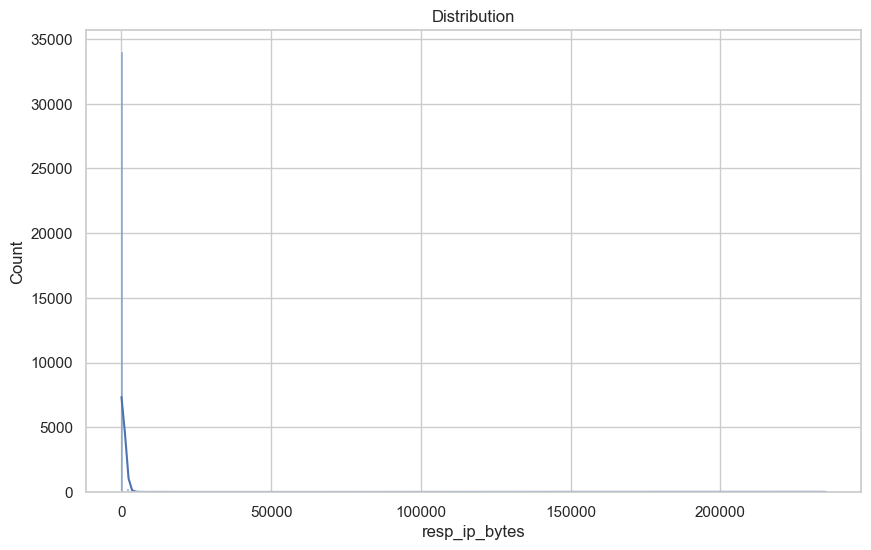

In [45]:
# Plot distributions for each numeric column
for i in numeric_cols:
    sns.histplot(df1[i], kde=True)
    plt.title("Distribution")
    plt.show()

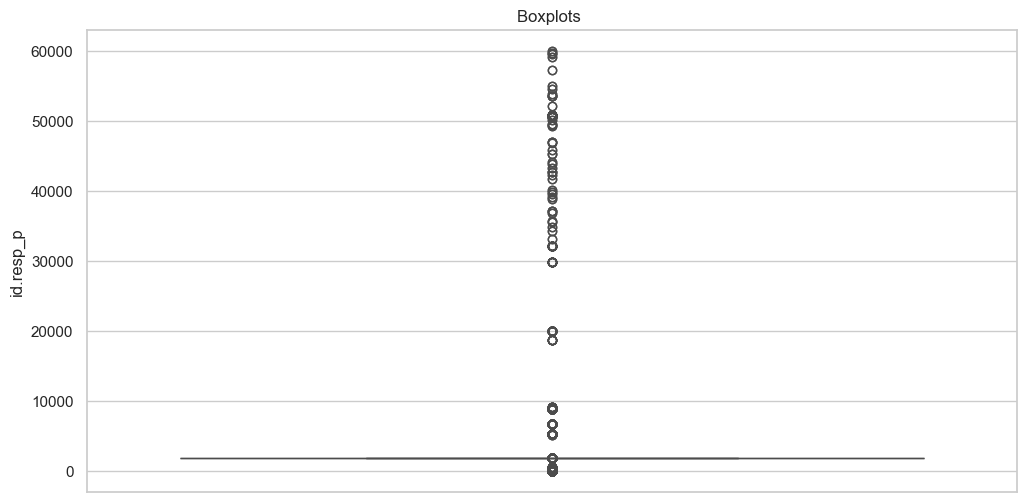

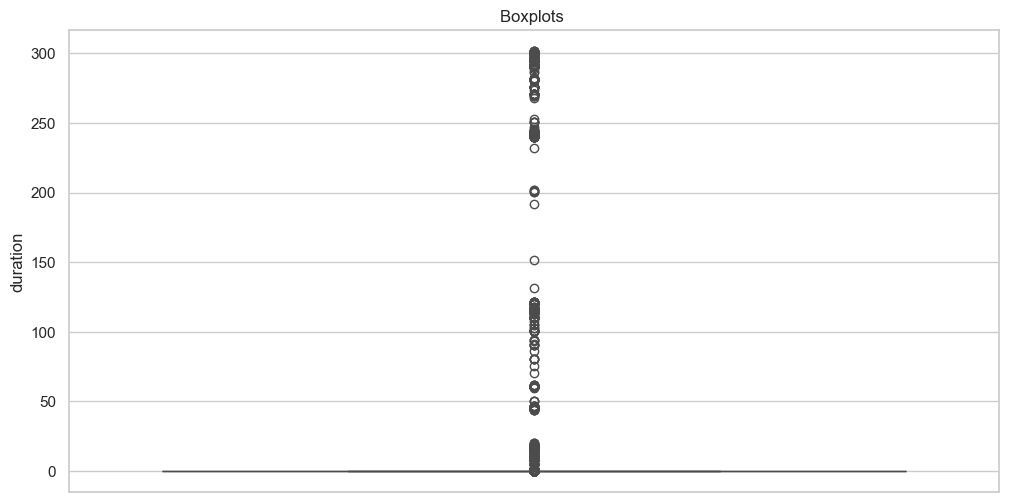

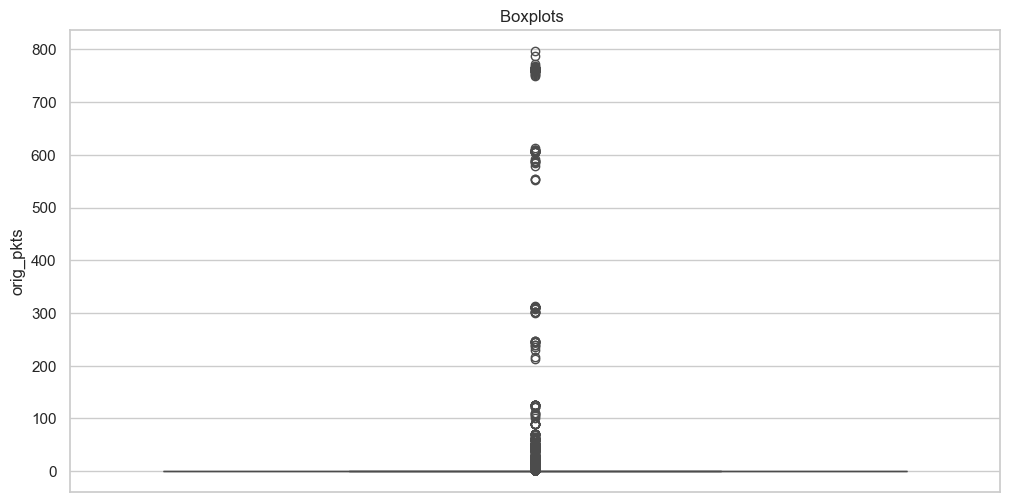

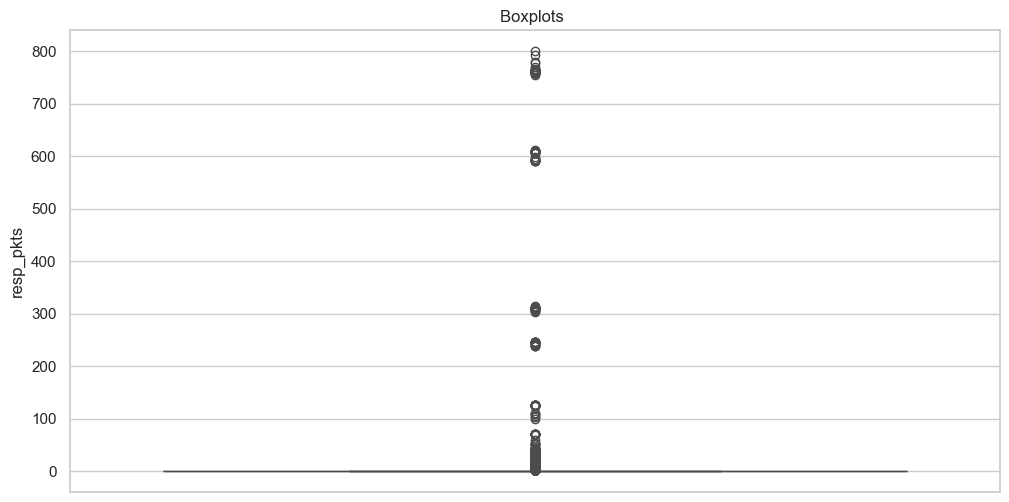

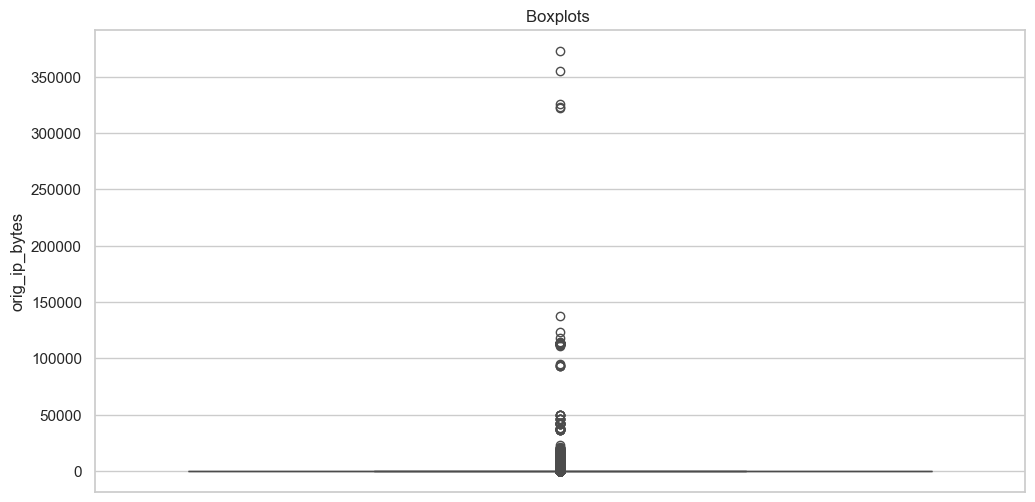

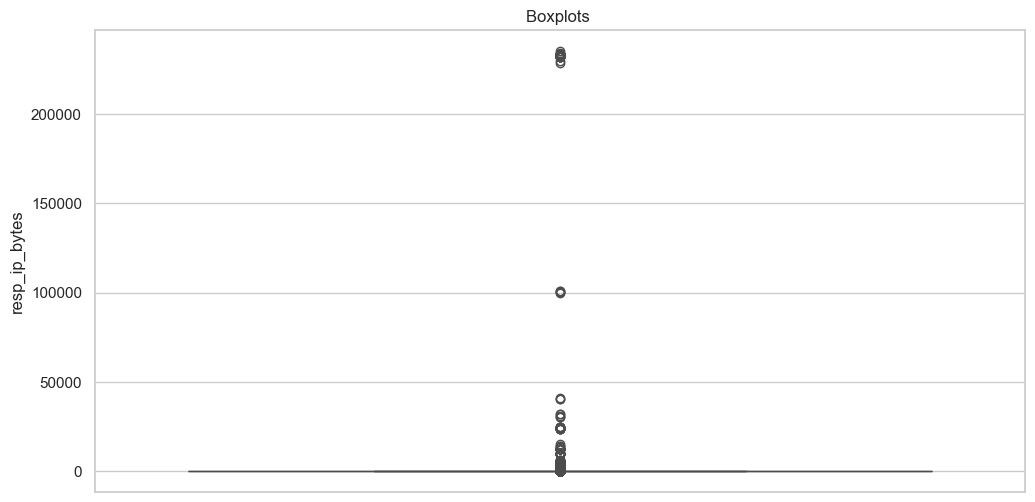

In [46]:
# Boxplots for each numeric column
for i in numeric_cols:
    plt.figure(figsize=(12,6))
    sns.boxplot(df1[i])
    plt.title("Boxplots ")
    plt.xticks(rotation=45)  
    plt.show()

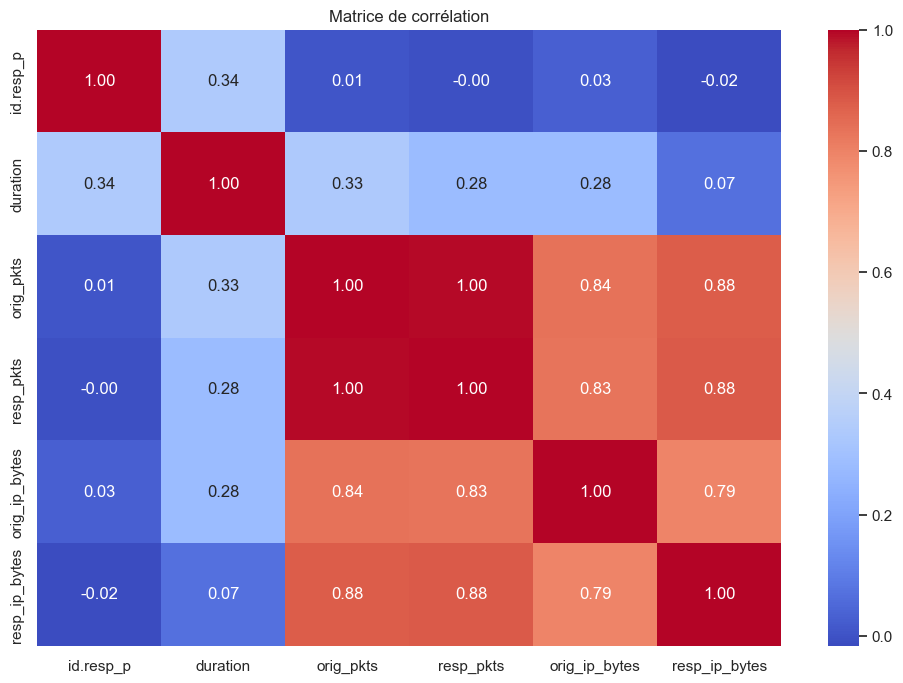

In [47]:
# selection of numeric columns
df_numeric = df1.select_dtypes(include=[np.number])

#calculate the correlation on df_numeric (and not df1)
corr = df_numeric.corr()

# show correlation heatmap
plt.figure(figsize=(12, 8)) # Optional: to enlarge the figure
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

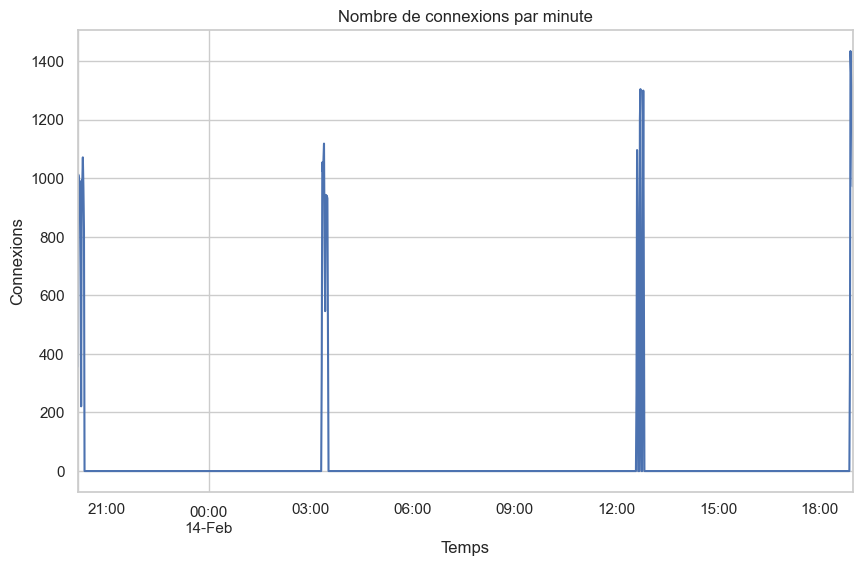

In [48]:
#Number of connections per minute
df1.set_index("ts", inplace=True)

connections_per_min = df1.resample("1min").size()

connections_per_min.plot()
plt.title("Nombre de connexions par minute")
plt.xlabel("Temps")
plt.ylabel("Connexions")
plt.show()

In [49]:
#Identify highest traffic peaks
connections_per_min.sort_values(ascending=False).head(10)

ts
2025-02-14 18:54:00    1434
2025-02-14 18:55:00    1359
2025-02-14 18:56:00    1331
2025-02-14 12:43:00    1304
2025-02-14 18:57:00    1302
2025-02-14 12:48:00    1299
2025-02-14 12:42:00    1203
2025-02-14 03:24:00    1118
2025-02-14 12:37:00    1096
2025-02-13 20:18:00    1071
dtype: int64

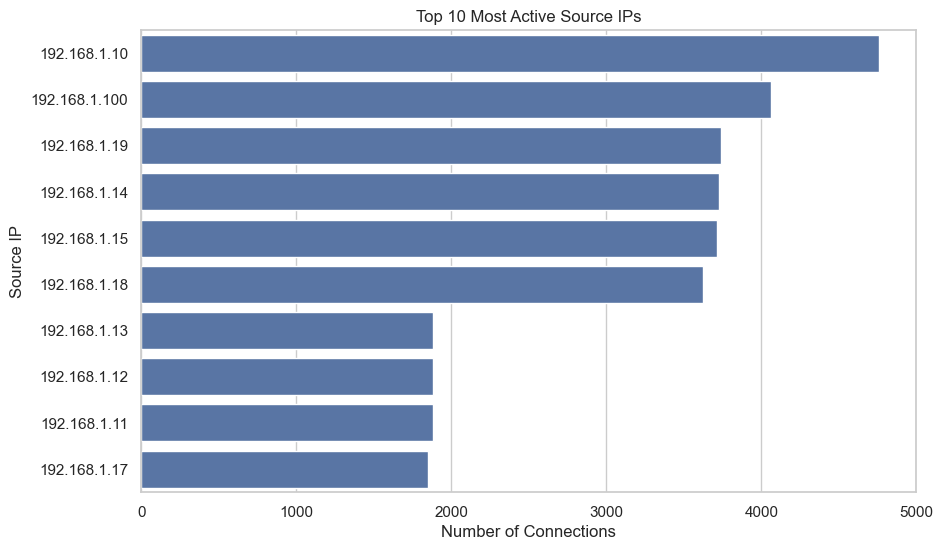

In [50]:
#Top 10 most active source IPs
top_ips = df1["id.orig_h"].value_counts().head(10)

sns.barplot(x=top_ips.values, y=top_ips.index)
plt.title("Top 10 Most Active Source IPs")
plt.xlabel("Number of Connections")
plt.ylabel("Source IP")
plt.show()

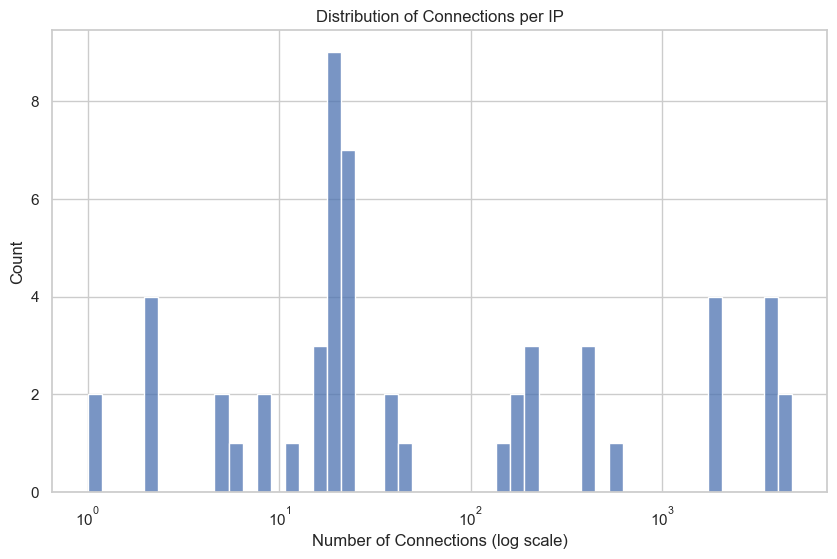

In [51]:
#Distribution of connections per IP
ip_counts = df1["id.orig_h"].value_counts()

sns.histplot(ip_counts, bins=50, log_scale=True)
plt.title("Distribution of Connections per IP")
plt.xlabel("Number of Connections (log scale)")
plt.show()

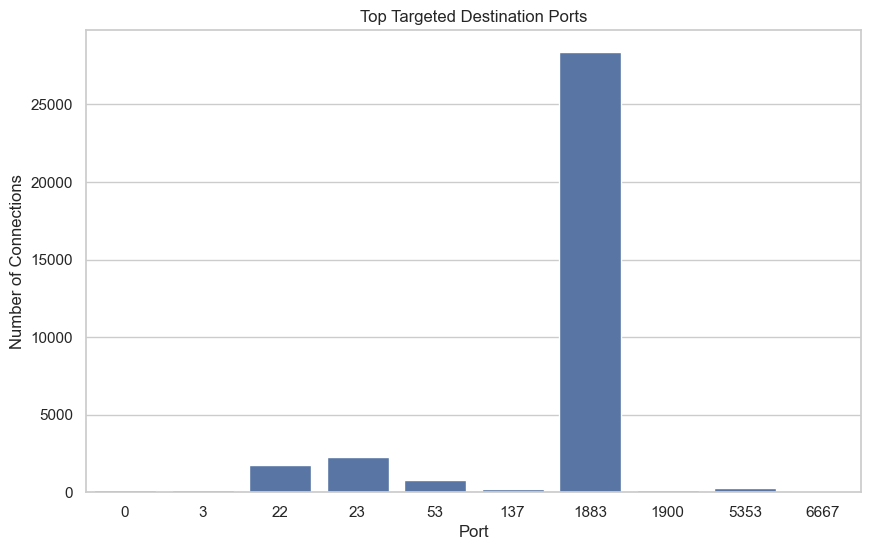

In [52]:
#Most targeted destination ports
top_ports = df1["id.resp_p"].value_counts().head(10)

sns.barplot(x=top_ports.index, y=top_ports.values)
plt.title("Top Targeted Destination Ports")
plt.xlabel("Port")
plt.ylabel("Number of Connections")
plt.show()

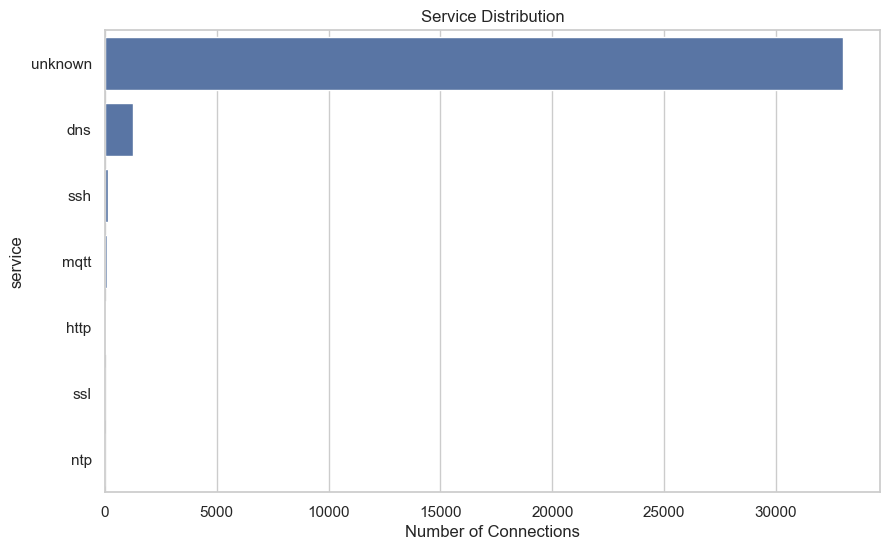

In [53]:
#Service distribution
top_services = df1["service"].value_counts()

sns.barplot(x=top_services.values, y=top_services.index)
plt.title("Service Distribution")
plt.xlabel("Number of Connections")
plt.show()

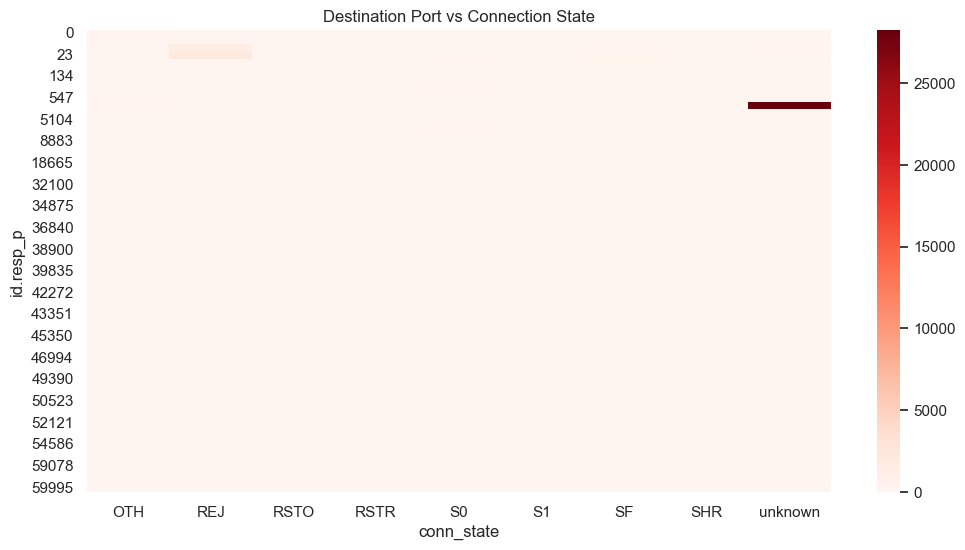

In [54]:
#Port vs connection state heatmap
pivot = pd.crosstab(df1["id.resp_p"], df1["conn_state"])

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap="Reds")
plt.title("Destination Port vs Connection State")
plt.show()

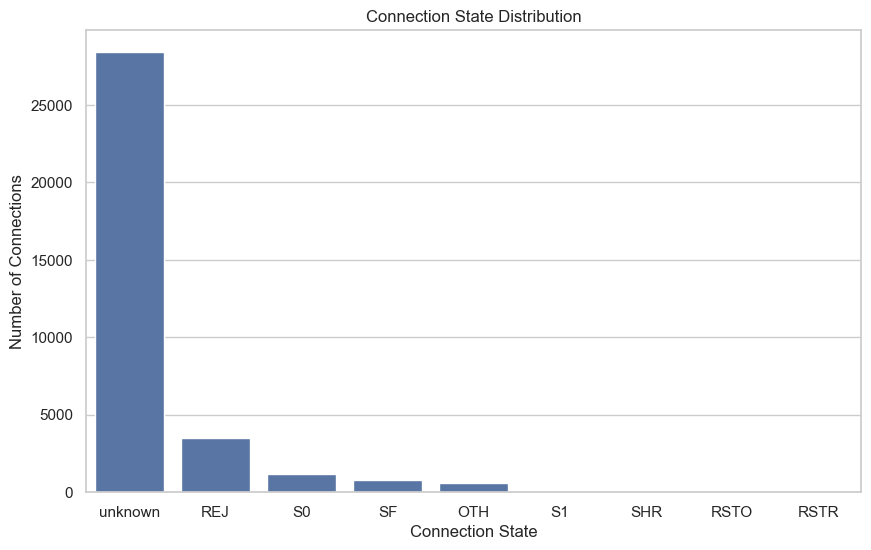

In [55]:
#Connection state analysis (conn_state)
conn_state_counts = df1["conn_state"].value_counts()

sns.barplot(x=conn_state_counts.index, y=conn_state_counts.values)
plt.title("Connection State Distribution")
plt.xlabel("Connection State")
plt.ylabel("Number of Connections")
plt.show()

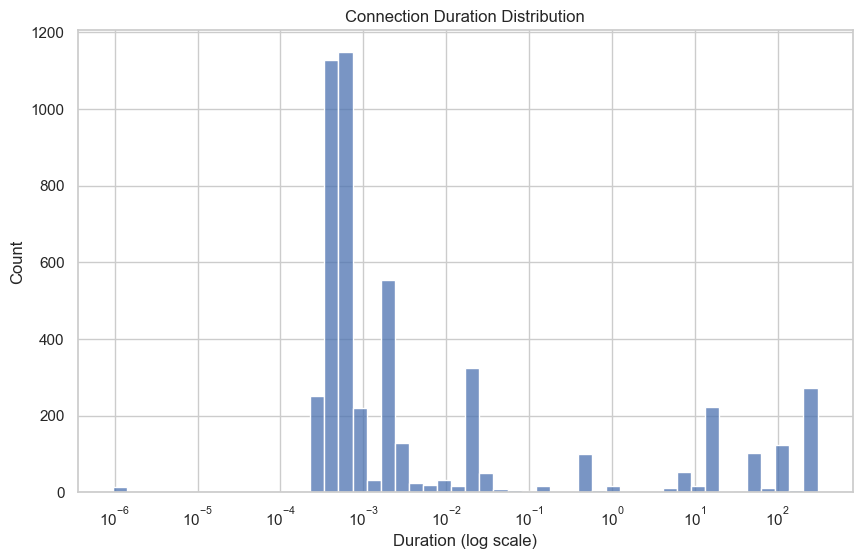

In [56]:
#Connection duration distribution
sns.histplot(df1["duration"], bins=50, log_scale=True)
plt.title("Connection Duration Distribution")
plt.xlabel("Duration (log scale)")
plt.show()

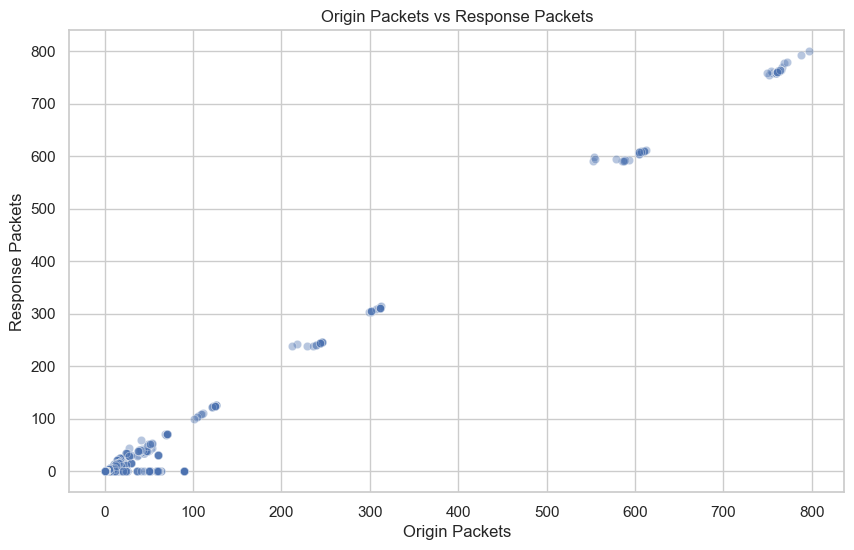

In [57]:
#Sent packets vs received packets
sns.scatterplot(
    x=df1["orig_pkts"],
    y=df1["resp_pkts"],
    alpha=0.4
)

plt.title("Origin Packets vs Response Packets")
plt.xlabel("Origin Packets")
plt.ylabel("Response Packets")
plt.show()

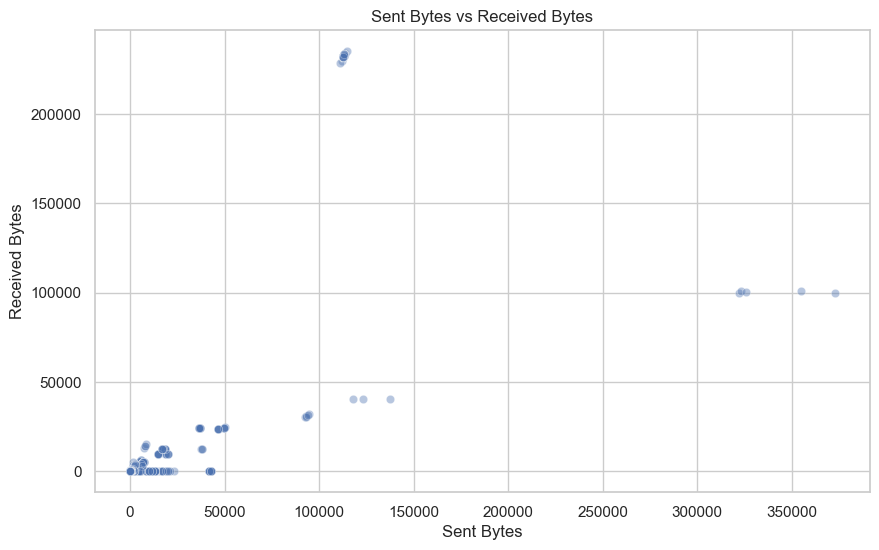

In [58]:
#Sent bytes vs received bytes
sns.scatterplot(
    x=df1["orig_ip_bytes"],
    y=df1["resp_ip_bytes"],
    alpha=0.4
)

plt.title("Sent Bytes vs Received Bytes")
plt.xlabel("Sent Bytes")
plt.ylabel("Received Bytes")
plt.show()

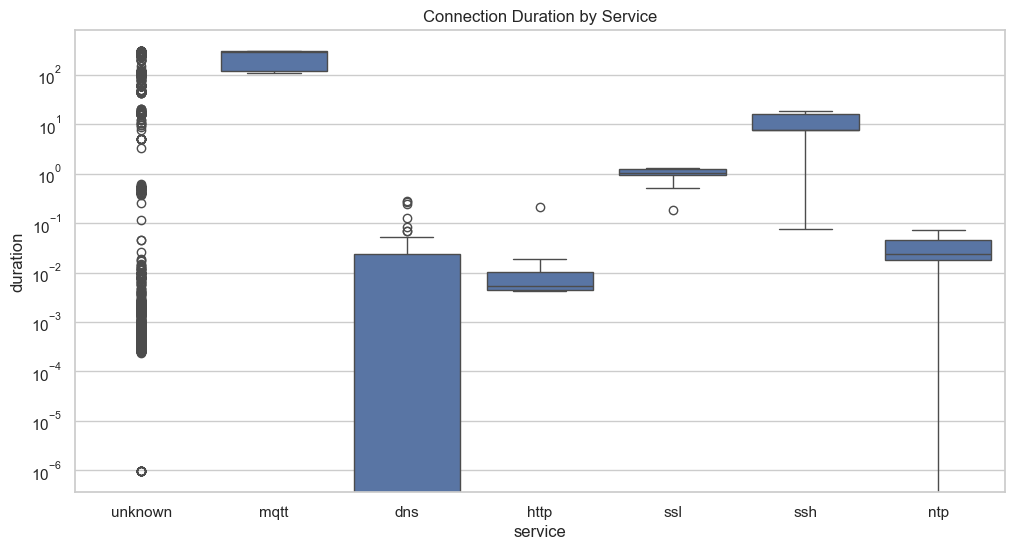

In [59]:
#Duration by service (boxplot)
plt.figure(figsize=(12,6))
sns.boxplot(x="service", y="duration", data=df1)
plt.yscale("log")
plt.title("Connection Duration by Service")
plt.show()

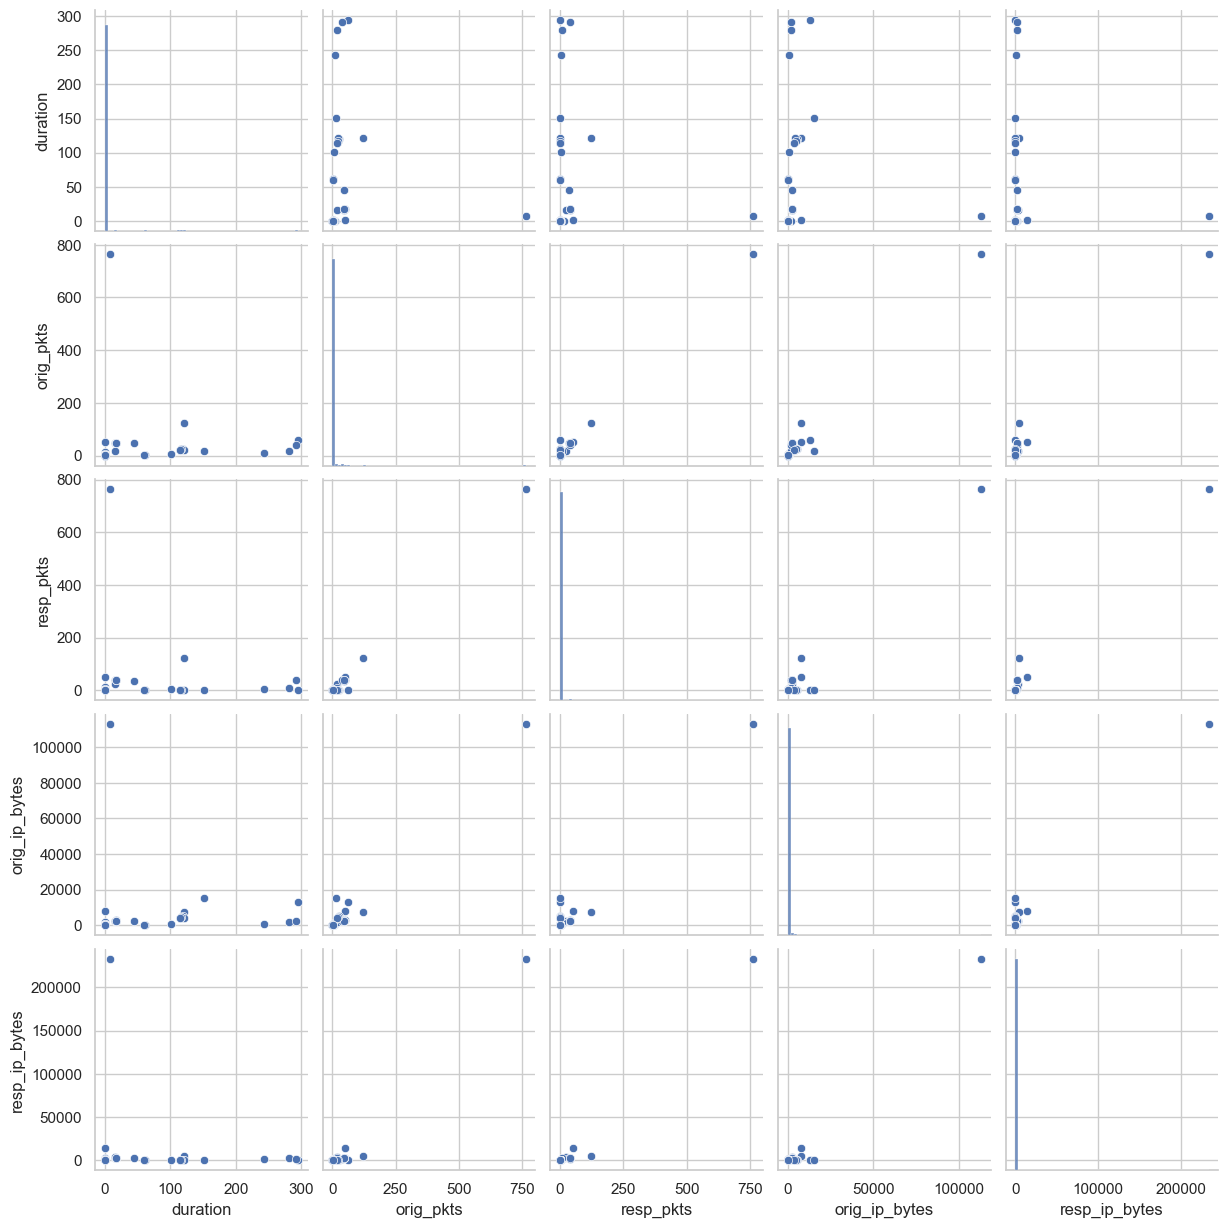

In [60]:
#Pairplot (sampled for performance)
sample_df = df1[[
    "duration",
    "orig_pkts",
    "resp_pkts",
    "orig_ip_bytes",
    "resp_ip_bytes"
]].sample(1000)

sns.pairplot(sample_df)
plt.show()


During the Exploratory Data Analysis (EDA) phase, we first evaluated the quality and completeness of the dataset. Columns with more than 99.9% missing values were removed to reduce noise and improve data reliability. After this filtering step, a subset of core features relevant to brute force attack detection was retained, including timestamps, source IP addresses, destination ports, services, connection states, packet counts, and traffic volume metrics. Missing numerical values were replaced with zeros to represent incomplete or failed connections, while missing categorical values were labeled as “unknown.” This preprocessing resulted in a clean and consistent dataset suitable for behavioral analysis.

The analysis of traffic patterns reveals clear evidence of an automated brute force attack. Temporal visualizations show sudden, high-intensity bursts of network connections exceeding 1,400 connections per minute, separated by periods of inactivity—an on–off pattern typical of scripted or botnet-driven attacks. Statistical distributions are heavily skewed toward near-zero values for duration and traffic volume, indicating rapid and repetitive connection failures. Additionally, traffic is highly concentrated on specific ports, notably Port 1883 (MQTT) and Ports 22/23 (SSH/Telnet), with most connections ending in rejected or undefined states. A small number of source IPs generate the majority of the traffic, confirming coordinated and non-human behavior. These characteristics demonstrate that the dataset predominantly represents automated brute force activity rather than legitimate user traffic.